In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [97]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load and Inspect the Data

In [98]:
df = pd.read_csv("airsim_spoofed_labeled_20250714-095130.txt")
df.head()

,TIME,POS_X,POS_Y,POS_Z,VEL_X,VEL_Y,VEL_Z,LABEL,SPOOF_TYPE
0,1.752501e+09,13.238,3.755,-1.846,1.874,1.726,0.626,0,none
1,1.752501e+09,13.976,4.304,-2.708,-0.620,-0.821,-0.862,0,none
2,1.752501e+09,13.260,2.343,-2.626,-0.480,-2.828,0.522,0,none
3,1.752501e+09,13.449,0.521,-3.153,0.714,-0.382,-0.347,0,none
4,1.752501e+09,14.645,0.778,-3.008,1.445,0.692,0.265,0,none


## Preprocess the Data

In [99]:
# Convert TIME to float if needed
df['TIME'] = df['TIME'].astype(float)

# Convert LABEL to integer
df['LABEL'] = df['LABEL'].astype(int)

# Drop spoof_type column (optional for now)
df = df.drop(columns=['SPOOF_TYPE'])

features = ['POS_X', 'POS_Y', 'POS_Z', 'VEL_X', 'VEL_Y', 'VEL_Z']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

## Create Sliding Windows for LSTM Input

In [100]:
def create_sequences(df, window_size=10):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq = df[features].iloc[i:i+window_size].values
        label = df['LABEL'].iloc[i+window_size-1]  # label of the last timestep
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

X, y = create_sequences(df)

## Train/Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Build and Train the LSTM Model

In [102]:
model = Sequential([
    #LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(64, input_shape=(X.shape[1], X.shape[2]))),
    Dropout(0.3), # helps generalize better
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=3,              # Stop after 3 epochs without improvement
    restore_best_weights=True # Revert to the best weights
)

checkpoint = ModelCheckpoint(
    'best_model.keras',             # File to save to
    monitor='val_loss',          # Track validation loss
    save_best_only=True,         # Only save when val_loss improves
    verbose=1
)

# Add it to callbacks list
callbacks = [early_stop, checkpoint]

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, class_weight={0: 1, 1: 5}, callbacks=callbacks)

Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6562 - loss: 0.8572
Epoch 1: val_loss improved from inf to 0.66760, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6232 - loss: 0.8702 - val_accuracy: 0.5946 - val_loss: 0.6676
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8438 - loss: 0.8141
Epoch 2: val_loss improved from 0.66760 to 0.65285, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7772 - loss: 0.8237 - val_accuracy: 0.5676 - val_loss: 0.6529
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8438 - loss: 0.7674
Epoch 3: val_loss improved from 0.65285 to 0.62818, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7803 - loss: 0.7805 - val_accuracy: 0.6216 - val_loss: 0.6282
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8750 - loss: 0.7533
Epoch 4: val_loss improved from 0.62818 to 0.59216, saving model to best_model.keras
5/5

## Evaluate the Model

In [103]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.75      0.86         4

    accuracy                           0.98        46
   macro avg       0.99      0.88      0.92        46
weighted avg       0.98      0.98      0.98        46

[[42  0]
 [ 1  3]]


## Confusion Matrix Heatmap

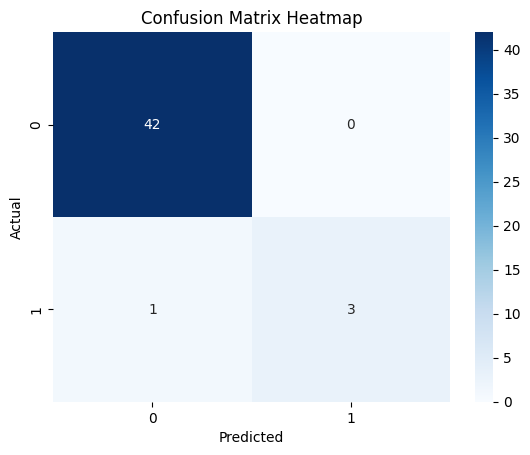

In [104]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Calculate ROC AUC

In [105]:
# Get predicted probabilities (needed for ROC AUC)
y_probs = model.predict(X_test)

# Calculate ROC AUC Score
auc_score = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {auc_score:.2f}")


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ROC AUC Score: 0.93


## Plot ROC Curve

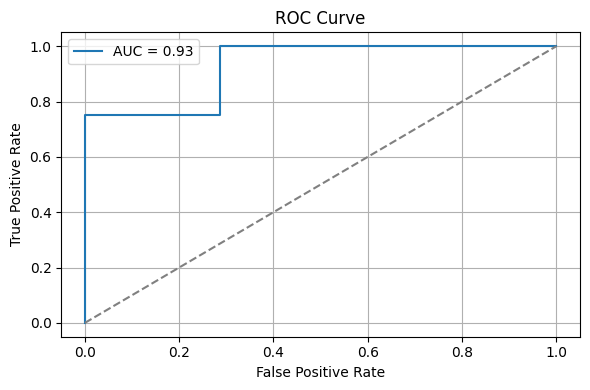

In [106]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 3D UAV Trajectory

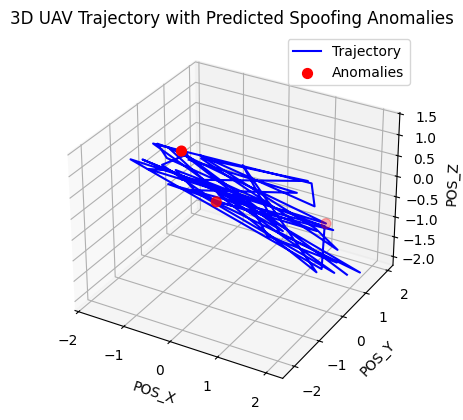

In [107]:
features = ['POS_X', 'POS_Y', 'POS_Z', 'VEL_X', 'VEL_Y', 'VEL_Z']
X = df[features].values
y = df['LABEL'].values

df_train, df_test = train_test_split(df, test_size=0.2, stratify=y, random_state=42)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Use the *original* values, not the scaled ones
# Example: these arrays must come from the same rows used in X_test
pos_x = df_test['POS_X'].values
pos_y = df_test['POS_Y'].values
pos_z = df_test['POS_Z'].values

# Plot full trajectory
ax.plot(pos_x, pos_y, pos_z, label='Trajectory', color='blue')

# Plot predicted spoofing windows
spoof_indices = np.where(y_pred == 1)[0]
ax.scatter(pos_x[spoof_indices], pos_y[spoof_indices], pos_z[spoof_indices],
           c='red', label='Anomalies', s=50)

ax.set_xlabel('POS_X')
ax.set_ylabel('POS_Y')
ax.set_zlabel('POS_Z')
ax.legend()
plt.title('3D UAV Trajectory with Predicted Spoofing Anomalies')
plt.show()